# VSB Power Line Fault Detection: Propuesta Mario

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
#warnings.simplefilter('ignore')

In [2]:
# import warnings

# def function_that_warns():
#     warnings.warn("deprecated", DeprecationWarning)

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     function_that_warns()  # this will not show a warning

In [3]:
import pandas as pd
import numpy as np
import math
import pyarrow
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import *
import scipy.stats
import statsmodels.api as sm
from scipy import fftpack # Fast Fourier Transform functions
import copy
import gc
import os
import sys
import warnings
from IPython.core.display import display, HTML
import lightgbm as lgb
import numba
import sklearn
import sklearn.metrics
from sklearn.metrics import matthews_corrcoef, precision_recall_fscore_support
import pywt
from statsmodels.robust import mad
from scipy import signal
import random
from sklearn.model_selection import KFold

C:\Users\mguem\AppData\Local\Temp\ipykernel_10200\1987420892.py:17: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
# Limpiar memoria
gc.collect()

0

### Carga y exploración

In [5]:
# Definir directorio de trabajo

data_dir = 'C://Users//mguem//Google Drive//UOC_MasterBusinesInteligenceBigDataAnalytics//TFM//Data//vsb-power-line-fault-detection'

In [6]:
# Cargar metadatos: train y test

meta_train_df = pd.read_csv(data_dir + '//metadata_train.csv')
meta_test_df = pd.read_csv(data_dir + '//metadata_test.csv')

In [7]:
# Explorar meta_train_df

meta_train_df.shape
meta_train_df

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1
...,...,...,...,...
8707,8707,2902,1,0
8708,8708,2902,2,0
8709,8709,2903,0,0
8710,8710,2903,1,0


In [8]:
# Valores nulos

meta_train_df.isnull().sum()

signal_id         0
id_measurement    0
phase             0
target            0
dtype: int64

C:\Users\mguem\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0    2904
1    2904
2    2904
Name: phase, dtype: int64

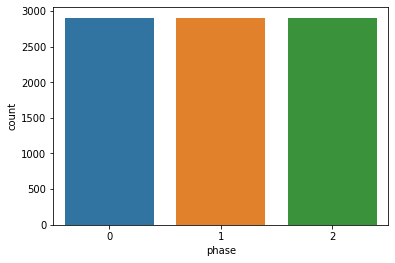

In [9]:
# Ploteamos la distribucion de fases

sns.countplot(meta_train_df['phase'])
meta_train_df.phase.value_counts()

Negativo (no dañada); target=0  8187
Positivo (dañada); target=1  525
Ratio dañada 0.0603


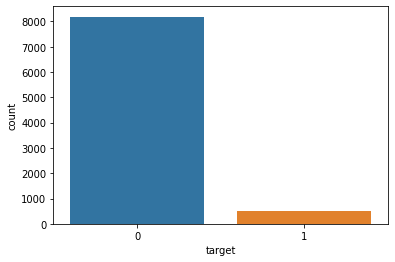

In [10]:
# Ploteamos la distribución de clases

sns.countplot(x="target", data=meta_train_df)

target_count = meta_train_df.target.value_counts()
print("Negativo (no dañada); target=0  {}".format(target_count[0]))
print("Positivo (dañada); target=1  {}".format(target_count[1]))
print("Ratio dañada {:.3}".format((target_count[1]/(target_count[0]+target_count[1]))))

Negativo fase 0 (no dañada); target=0  2726
Positivo fase 0 (dañada); target=1  178
Ratio dañada fase 0 0.0613
Negativo fase 1 (no dañada); target=0  2738
Positivo fase 1 (dañada); target=1  166
Ratio dañada fase 1 0.0572
Negativo fase 2 (no dañada); target=0  2723
Positivo fase 2 (dañada); target=1  181
Ratio dañada fase 2 0.0623


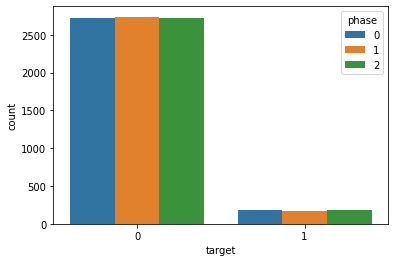

In [11]:
# Ploteamos la distribución de clases por fase

sns.countplot(x="target", data=meta_train_df, hue="phase")

target_count_phase0 = meta_train_df[meta_train_df.phase == 0].target.value_counts()
print("Negativo fase 0 (no dañada); target=0  {}".format(target_count_phase0[0]))
print("Positivo fase 0 (dañada); target=1  {}".format(target_count_phase0[1]))
print("Ratio dañada fase 0 {:.3}".format((target_count_phase0[1]/(target_count_phase0[0]+target_count_phase0[1]))))

target_count_phase1 = meta_train_df[meta_train_df.phase == 1].target.value_counts()
print("Negativo fase 1 (no dañada); target=0  {}".format(target_count_phase1[0]))
print("Positivo fase 1 (dañada); target=1  {}".format(target_count_phase1[1]))
print("Ratio dañada fase 1 {:.3}".format((target_count_phase1[1]/(target_count_phase1[0]+target_count_phase1[1]))))

target_count_phase2 = meta_train_df[meta_train_df.phase == 2].target.value_counts()
print("Negativo fase 2 (no dañada); target=0  {}".format(target_count_phase2[0]))
print("Positivo fase 2 (dañada); target=1  {}".format(target_count_phase2[1]))
print("Ratio dañada fase 2 {:.3}".format((target_count_phase2[1]/(target_count_phase2[0]+target_count_phase2[1]))))

In [12]:
# Explorar meta_test_df

meta_test_df.shape
meta_test_df

,signal_id,id_measurement,phase
0,8712,2904,0
1,8713,2904,1
2,8714,2904,2
3,8715,2905,0
4,8716,2905,1
...,...,...,...
20332,29044,9681,1
20333,29045,9681,2
20334,29046,9682,0
20335,29047,9682,1


In [13]:
# Valores nulos

meta_test_df.isnull().sum()

signal_id         0
id_measurement    0
phase             0
dtype: int64

C:\Users\mguem\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0    6779
1    6779
2    6779
Name: phase, dtype: int64

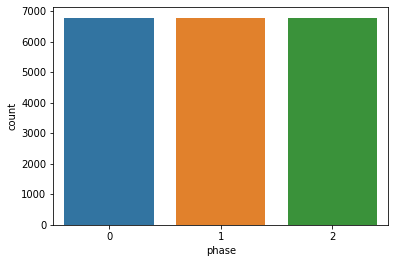

In [14]:
# Ploteamos la distribucion de fases

sns.countplot(meta_test_df['phase'])
meta_test_df.phase.value_counts()

In [41]:
# Cargar datos de entrenamiento
# Error de memorial al cargar todos los datos
# Definir parametros para cargar en bloques

trainLength = 8712
trainEnd = trainLength
chunkSize = 250
nChunks = math.floor(trainLength/chunkSize)
lastChunkStart = chunkSize*nChunks

#First chunk
signals = pq.read_table(data_dir + '\\train.parquet', columns=[str(i) for i in range(chunkSize)]).to_pandas()

#nchunks
for i in range (1, nChunks):
    signals1 = pq.read_table(data_dir + '\\train.parquet', columns=[str(j) for j in range(chunkSize*i,(chunkSize*(i+1)))]).to_pandas()
    signals = pd.concat([signals, signals1], axis=1)

#Last chunk
lastChunk = pq.read_table(data_dir + '\\train.parquet', columns=[str(k) for k in range(lastChunkStart, trainEnd)]).to_pandas()

#Concat
train_df = pd.concat([signals, lastChunk], axis=1)

In [33]:
# Explorar train_df

train_df.shape
train_df

,0,1,2,3,4,5,6,7,8,9,...,8702,8703,8704,8705,8706,8707,8708,8709,8710,8711
0,17.914977,0.406196,-19.117399,-15.893545,-4.850237,19.776304,-15.844929,16.226338,-0.896548,-15.494044,...,18,-22,12,8,13,6,-21,-15,-9,20
1,17.914913,0.406711,-19.117398,-15.951246,-4.937643,19.767070,-15.829162,16.248788,-0.896541,-15.312961,...,17,-21,12,8,14,7,-19,-15,-8,21
2,17.914848,0.407228,-19.117398,-16.022771,-5.051075,19.756555,-15.812978,16.271805,-0.896535,-15.083881,...,16,-21,13,8,15,8,-18,-14,-8,22
3,17.914785,0.407732,-19.117394,-16.068105,-5.105293,19.748731,-15.799054,16.291745,-0.896524,-14.948554,...,16,-21,12,8,15,8,-19,-14,-7,23
4,17.914724,0.408221,-19.117386,-16.086148,-5.096570,19.743738,-15.787752,16.308122,-0.896508,-14.913762,...,17,-22,12,8,15,8,-18,-14,-8,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,17.915296,0.403643,-19.117406,-15.746102,-4.681876,19.808988,-15.916285,16.124090,-0.896584,-15.824854,...,18,-20,12,9,14,6,-20,-14,-7,22
799996,17.915233,0.404152,-19.117404,-15.752274,-4.675961,19.804726,-15.902636,16.143677,-0.896577,-15.866249,...,18,-20,13,9,14,6,-20,-13,-7,23
799997,17.915169,0.404662,-19.117402,-15.771318,-4.690429,19.799192,-15.888796,16.163544,-0.896569,-15.837557,...,18,-20,13,9,13,6,-20,-14,-7,23
799998,17.915106,0.405170,-19.117400,-15.813302,-4.741502,19.791465,-15.875123,16.183243,-0.896562,-15.726462,...,19,-19,13,10,14,6,-20,-14,-8,22


In [17]:
# Cargar 9 señales para pruebas
#signals_exploration = pq.read_table(data_dir + '\\train.parquet', columns=[str(i) for i in range(9)]).to_pandas()

Text(0, 0.5, 'Amplitud')

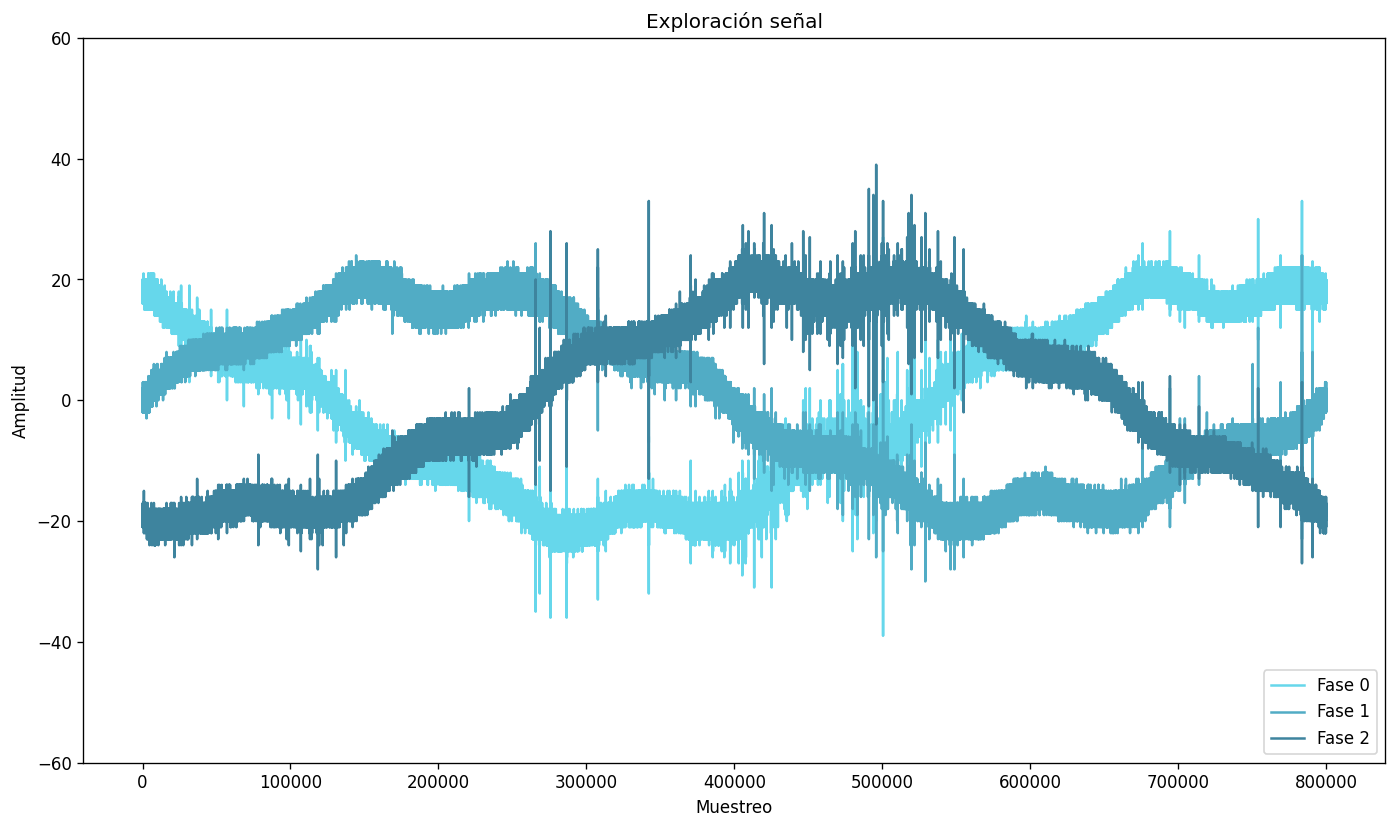

In [18]:
fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Fase 0', 'Fase 1', 'Fase 2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(train_df))), train_df["0"], '-', label=plot_labels[0], color=blues[0])
plt.plot(list(range(len(train_df))), train_df["1"], '-', label=plot_labels[1], color=blues[1])
plt.plot(list(range(len(train_df))), train_df["2"], '-', label=plot_labels[2], color=blues[2])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Exploración señal')
plt.xlabel('Muestreo')
plt.ylabel('Amplitud')

In [19]:
# Import metadata for the training set
#_, metadata_train = load_metadata_by_filter('train')
# Loop over id_measurements until 10 all-negative and 10 all-positive target value
# ids (i.e. id_measurement ids for which target values for the three phases are
# all 0 or all 1) have been identified.
negative_ids = []; positive_ids = []; max_ids = 10
for id_measurement in range(meta_train_df.id_measurement.max()):
    # Get metadata for id_measurement
    current_metadata = meta_train_df[meta_train_df.id_measurement == id_measurement]
    # If all target values are 0, add id to the negative list
    if((current_metadata.target == 0).all()):
        if(len(negative_ids) < max_ids): negative_ids.append(id_measurement)
    # If all target values are 1, add id to the positive list
    elif((current_metadata.target == 1).all()):
        if(len(positive_ids) < max_ids): positive_ids.append(id_measurement)
    # If 10 negative and 10 positive ids have been found, break from loop
    if((len(negative_ids) >= max_ids) & (len(positive_ids) >= max_ids)):
        break
# Print the negative and positive id_measurement values
print('ids negativos', negative_ids)
print('ids positivos', positive_ids)

ids negativos [0, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ids positivos [1, 76, 90, 93, 95, 98, 136, 144, 145, 152]


In [20]:
# Señales de la primera medida sin fallo

meta_train_df[meta_train_df.id_measurement.isin([0, 2, 3])]

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
6,6,2,0,0
7,7,2,1,0
8,8,2,2,0
9,9,3,0,0
10,10,3,1,0
11,11,3,2,0


In [21]:
meta_train_df[meta_train_df.id_measurement.isin([1, 74, 90])]

,signal_id,id_measurement,phase,target
3,3,1,0,1
4,4,1,1,1
5,5,1,2,1
222,222,74,0,0
223,223,74,1,0
224,224,74,2,0
270,270,90,0,1
271,271,90,1,1
272,272,90,2,1


Text(0, 0.5, 'Amplitud')

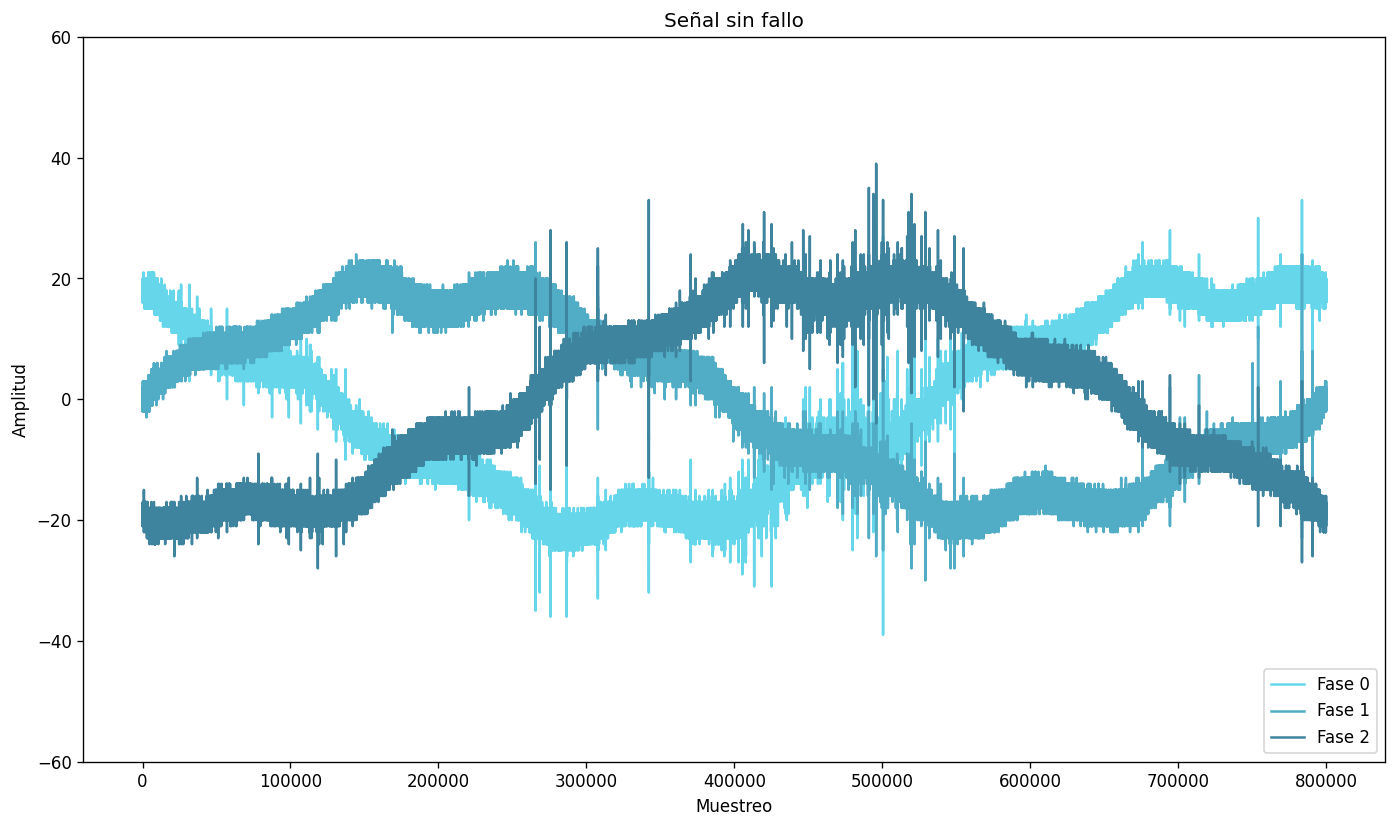

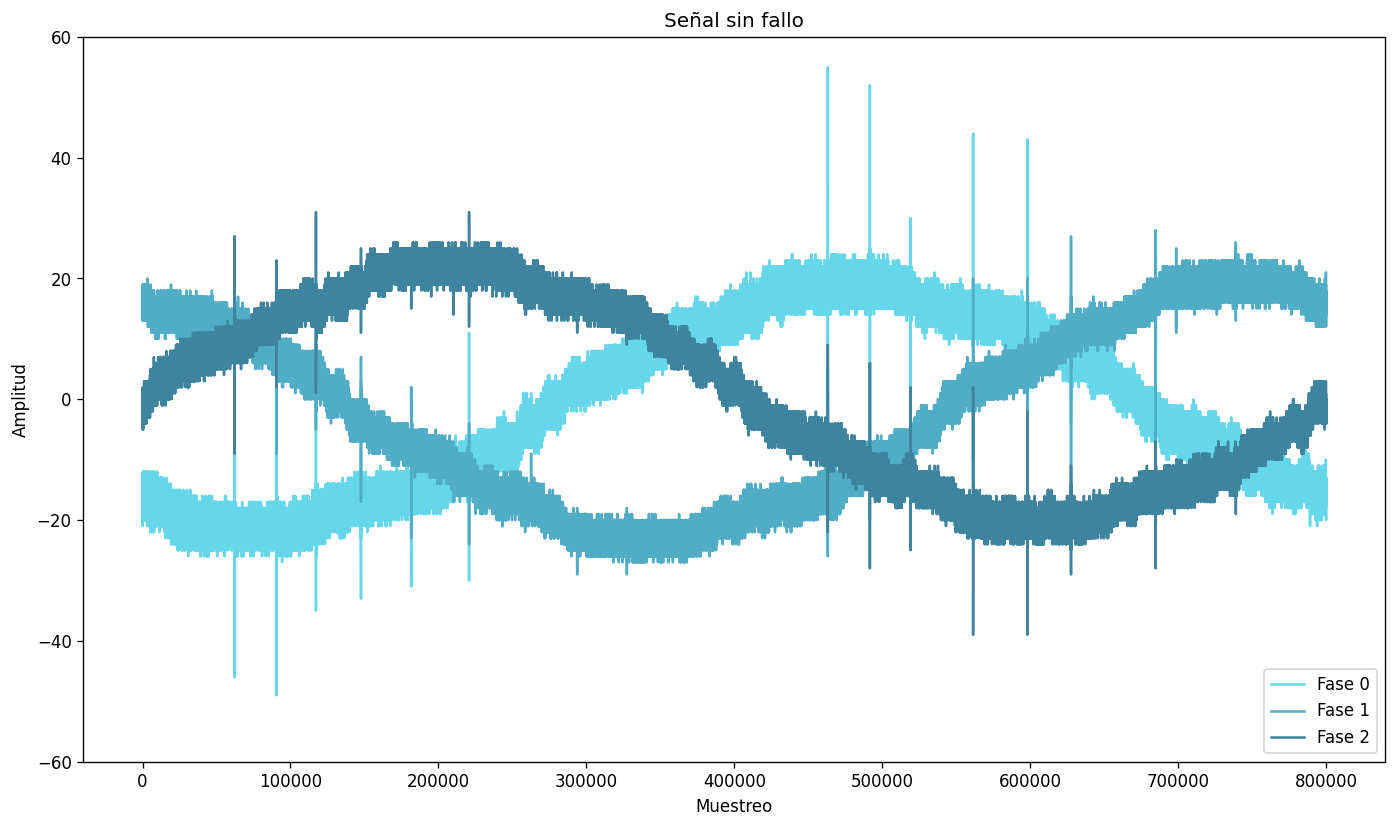

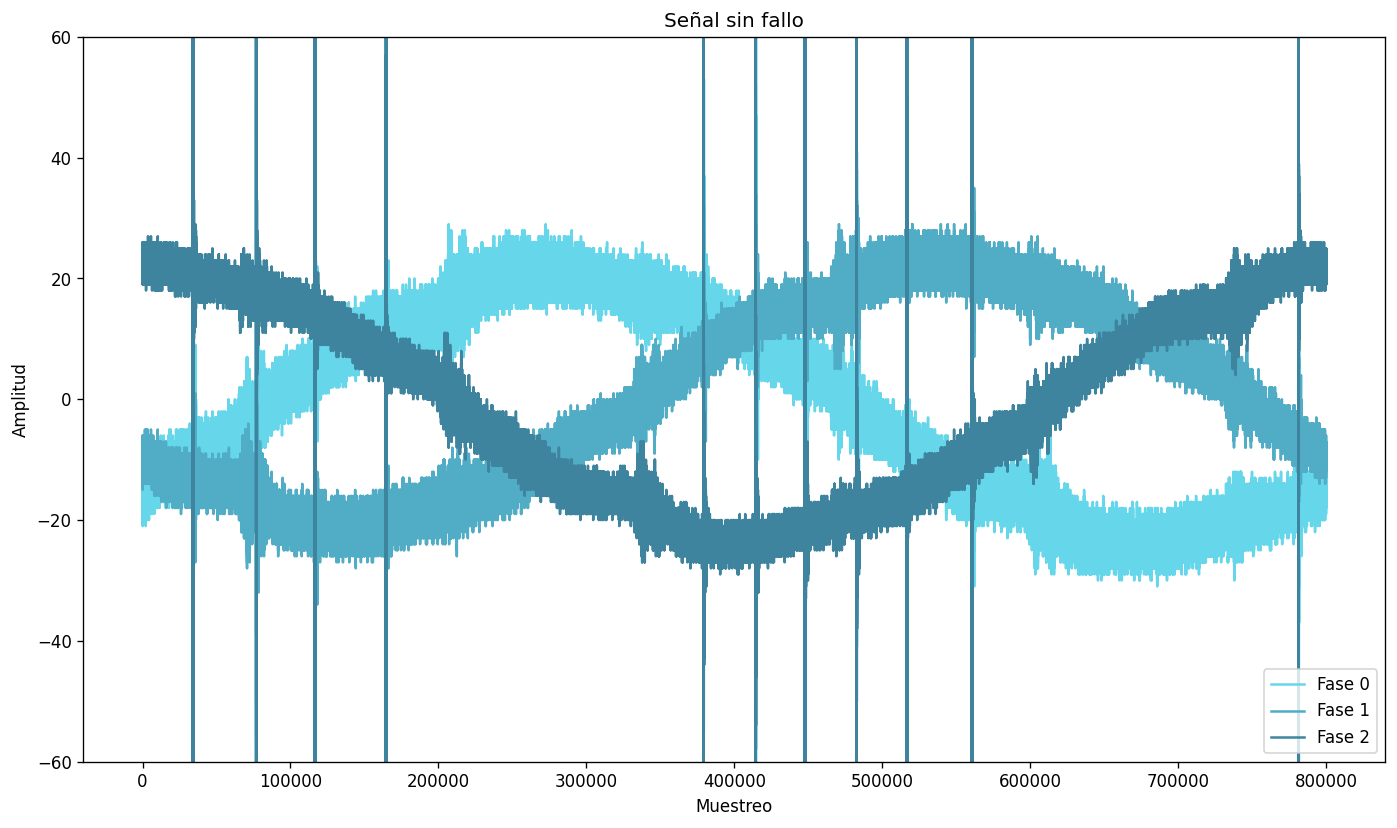

In [22]:
# Ploteamos 3 trios de señales sin fallo

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Fase 0', 'Fase 1', 'Fase 2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(train_df))), train_df["0"], '-', label=plot_labels[0], color=blues[0])
plt.plot(list(range(len(train_df))), train_df["1"], '-', label=plot_labels[1], color=blues[1])
plt.plot(list(range(len(train_df))), train_df["2"], '-', label=plot_labels[2], color=blues[2])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Señal sin fallo')
plt.xlabel('Muestreo')
plt.ylabel('Amplitud')

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Fase 0', 'Fase 1', 'Fase 2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(train_df))), train_df["6"], '-', label=plot_labels[0], color=blues[0])
plt.plot(list(range(len(train_df))), train_df["7"], '-', label=plot_labels[1], color=blues[1])
plt.plot(list(range(len(train_df))), train_df["8"], '-', label=plot_labels[2], color=blues[2])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Señal sin fallo')
plt.xlabel('Muestreo')
plt.ylabel('Amplitud')

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Fase 0', 'Fase 1', 'Fase 2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(train_df))), train_df["9"], '-', label=plot_labels[0], color=blues[0])
plt.plot(list(range(len(train_df))), train_df["10"], '-', label=plot_labels[1], color=blues[1])
plt.plot(list(range(len(train_df))), train_df["11"], '-', label=plot_labels[2], color=blues[2])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Señal sin fallo')
plt.xlabel('Muestreo')
plt.ylabel('Amplitud')

Text(0, 0.5, 'Amplitud')

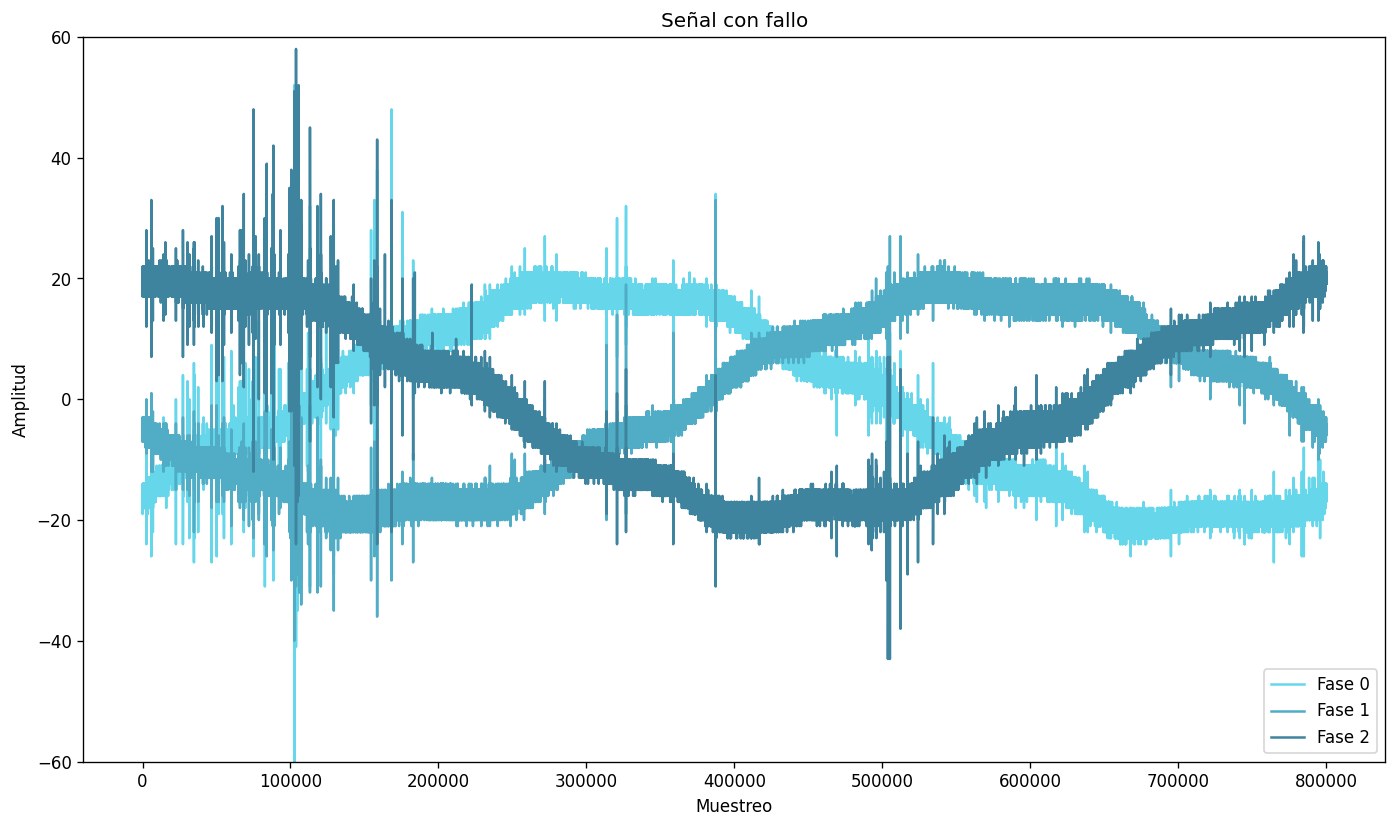

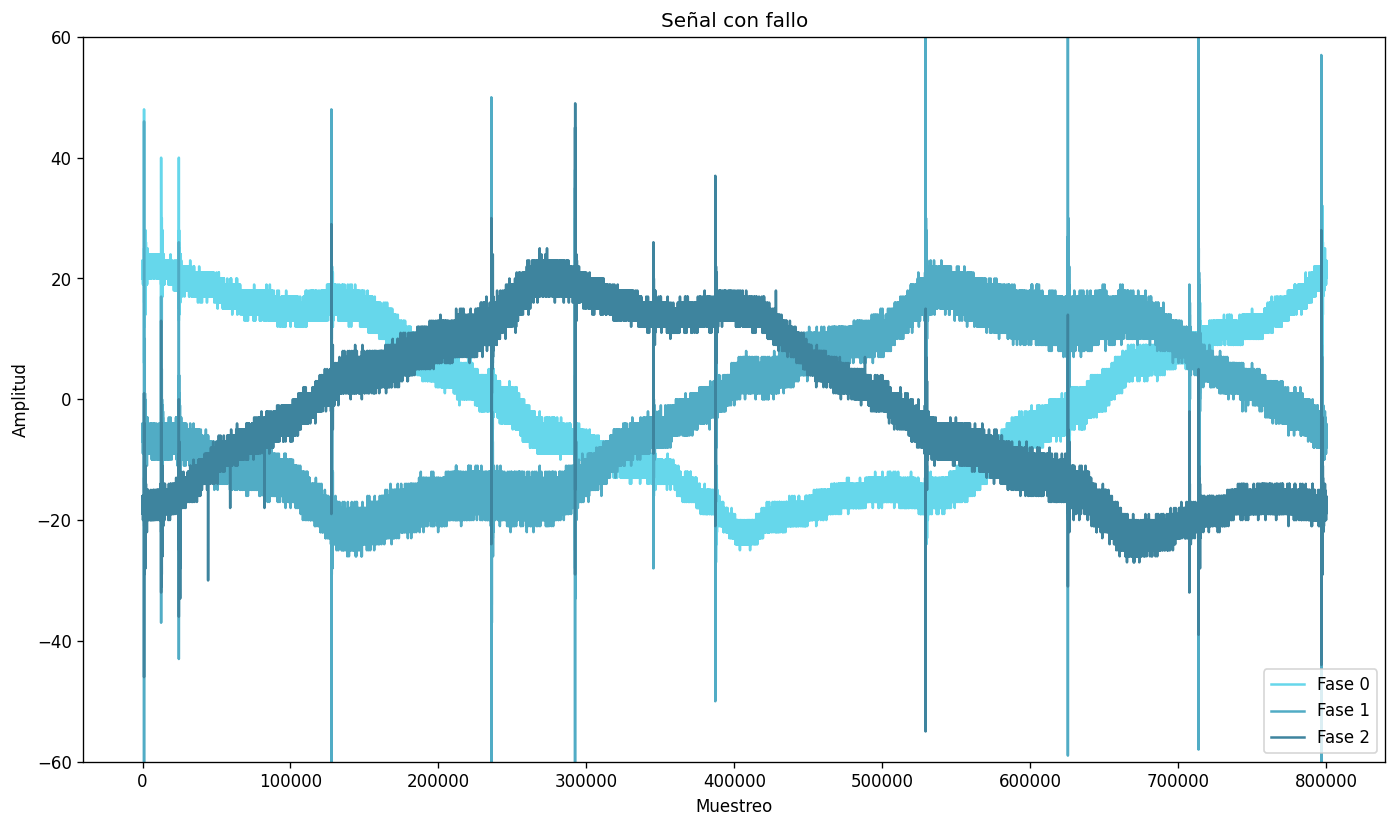

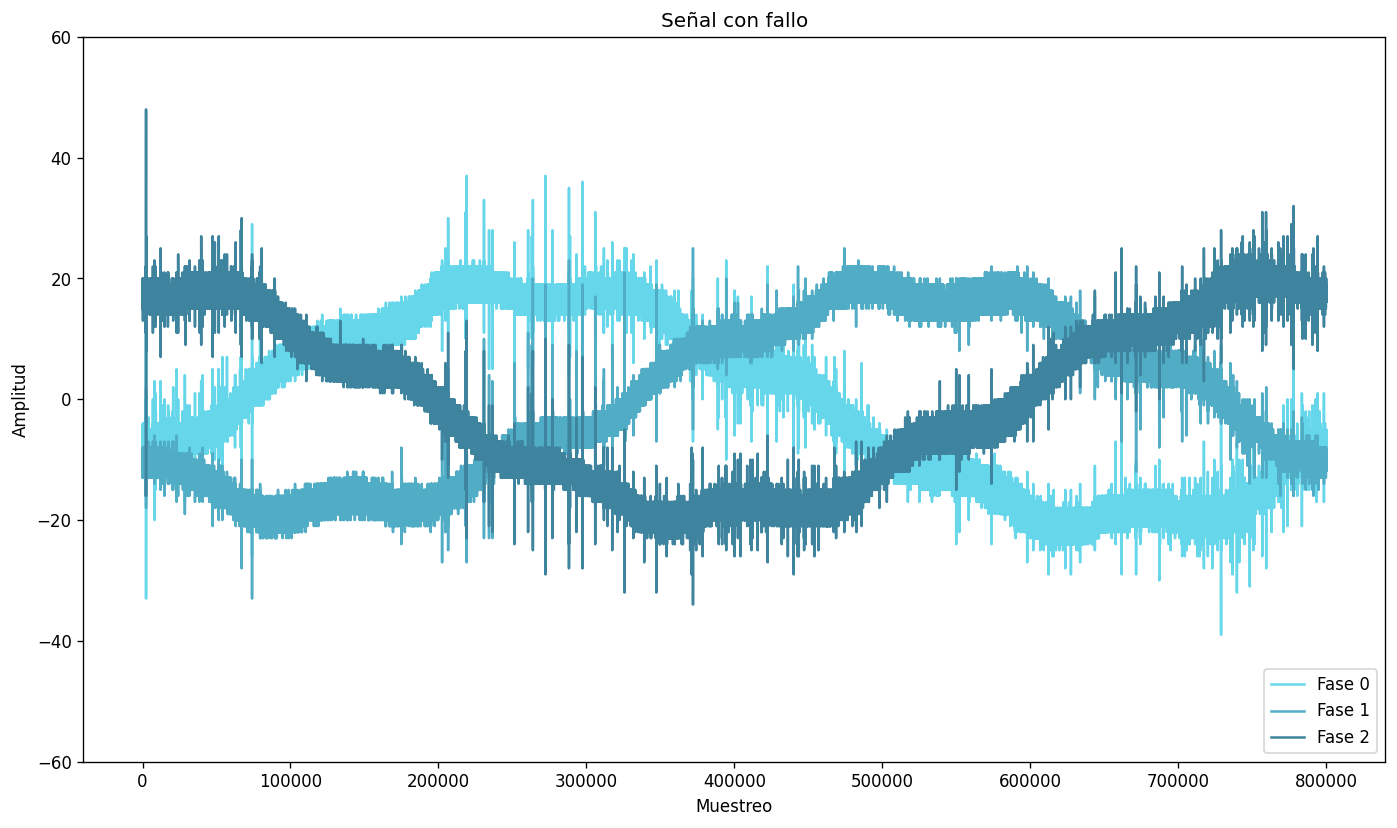

In [23]:
# Ploteamos 3 trios de señales con fallo

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Fase 0', 'Fase 1', 'Fase 2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(train_df))), train_df["3"], '-', label=plot_labels[0], color=blues[0])
plt.plot(list(range(len(train_df))), train_df["4"], '-', label=plot_labels[1], color=blues[1])
plt.plot(list(range(len(train_df))), train_df["5"], '-', label=plot_labels[2], color=blues[2])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Señal con fallo')
plt.xlabel('Muestreo')
plt.ylabel('Amplitud')

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Fase 0', 'Fase 1', 'Fase 2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(train_df))), train_df["222"], '-', label=plot_labels[0], color=blues[0])
plt.plot(list(range(len(train_df))), train_df["223"], '-', label=plot_labels[1], color=blues[1])
plt.plot(list(range(len(train_df))), train_df["224"], '-', label=plot_labels[2], color=blues[2])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Señal con fallo')
plt.xlabel('Muestreo')
plt.ylabel('Amplitud')

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Fase 0', 'Fase 1', 'Fase 2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(train_df))), train_df["270"], '-', label=plot_labels[0], color=blues[0])
plt.plot(list(range(len(train_df))), train_df["271"], '-', label=plot_labels[1], color=blues[1])
plt.plot(list(range(len(train_df))), train_df["272"], '-', label=plot_labels[2], color=blues[2])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Señal con fallo')
plt.xlabel('Muestreo')
plt.ylabel('Amplitud')

### Procesado y eliminación de ruido de fondo

In [24]:
# Definir transformación wavelet

 
def waveletSmooth( x, wavelet="db4", level=1):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    return y

In [52]:
# Aplicar wavelet a todo el dataframe de entrenamiento

wavelet_df = train_df.copy()

# for i in range(900) :
#         wavelet_df.iloc[:,i] =  waveletSmooth(train_df.iloc[:,i], wavelet="db4", level=1)
#         #signal_detrend =  detrend_signal(signal_wavelet) 
#         #signal_features = get_features(signal_detrend, i, threshold, min_distance)

# wavelet_df


trainLength = 8712
trainEnd = trainLength
chunkSize = 250
nChunks = math.floor(trainLength/chunkSize)
lastChunkStart = chunkSize*nChunks

#First chunk
signals_wavelet = pq.read_table(data_dir + '\\train.parquet', columns=[str(i) for i in range(chunkSize)]).to_pandas()
for i in range(chunkSize):
        wavelet_df.iloc[:,i] =  waveletSmooth(train_df.iloc[:,i], wavelet="db4", level=1)

#nchunks
for i in range (1, nChunks):
        for j in range(chunkSize*i,(chunkSize*(i+1))): 
                wavelet_df.iloc[:,i] =  waveletSmooth(train_df.iloc[:,j], wavelet="db4", level=1)

#Last chunk
lastChunk = pq.read_table(data_dir + '\\train.parquet', columns=[str(k) for k in range(lastChunkStart, trainEnd)]).to_pandas()
for k in range(lastChunkStart, trainEnd):
        wavelet_df.iloc[:,k] =  waveletSmooth(train_df.iloc[:,k], wavelet="db4", level=1)



MemoryError: Unable to allocate 191. MiB for an array with shape (250, 800000) and data type int8

In [51]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,8702,8703,8704,8705,8706,8707,8708,8709,8710,8711
0,18,1,-19,-16,-5,19,-15,15,-1,-16,...,18,-22,12,8,13,6,-21,-15,-9,20
1,18,0,-19,-17,-6,19,-17,16,0,-15,...,17,-21,12,8,14,7,-19,-15,-8,21
2,17,-1,-20,-17,-6,19,-17,15,-3,-15,...,16,-21,13,8,15,8,-18,-14,-8,22
3,18,1,-19,-16,-5,20,-16,16,0,-15,...,16,-21,12,8,15,8,-19,-14,-7,23
4,18,0,-19,-16,-5,20,-17,16,-2,-14,...,17,-22,12,8,15,8,-18,-14,-8,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,19,2,-18,-15,-4,21,-16,16,-1,-17,...,18,-20,12,9,14,6,-20,-14,-7,22
799996,19,1,-19,-15,-4,20,-17,15,-3,-18,...,18,-20,13,9,14,6,-20,-13,-7,23
799997,17,0,-19,-15,-4,21,-16,14,-2,-18,...,18,-20,13,9,13,6,-20,-14,-7,23
799998,19,1,-18,-14,-3,22,-16,17,-1,-17,...,19,-19,13,10,14,6,-20,-14,-8,22


In [64]:
# Wavelet para eliminar DSI (discrete spectral interference) y ruído ambiente y del propio equipo de medida

def waveletSmoothPlots( x, wavelet="db4", level=1, title=None ):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    plt.plot( x, color="#66D7EB", alpha=0.5, label="Original Signal")
    plt.plot( y, color="#1C3D52", label="Transformed Signal" )
    plt.ylim((-60, 60))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(y)))
    return y


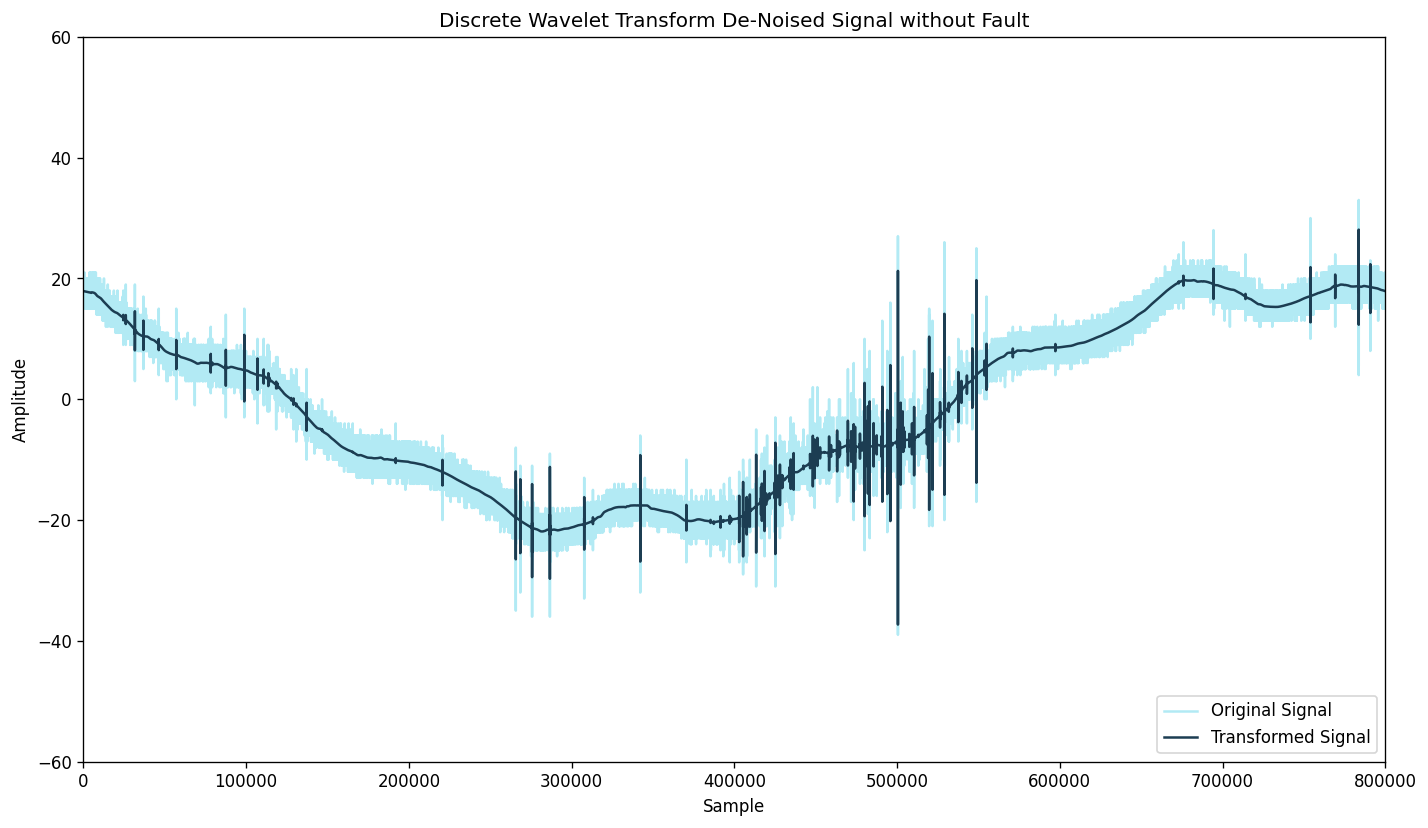

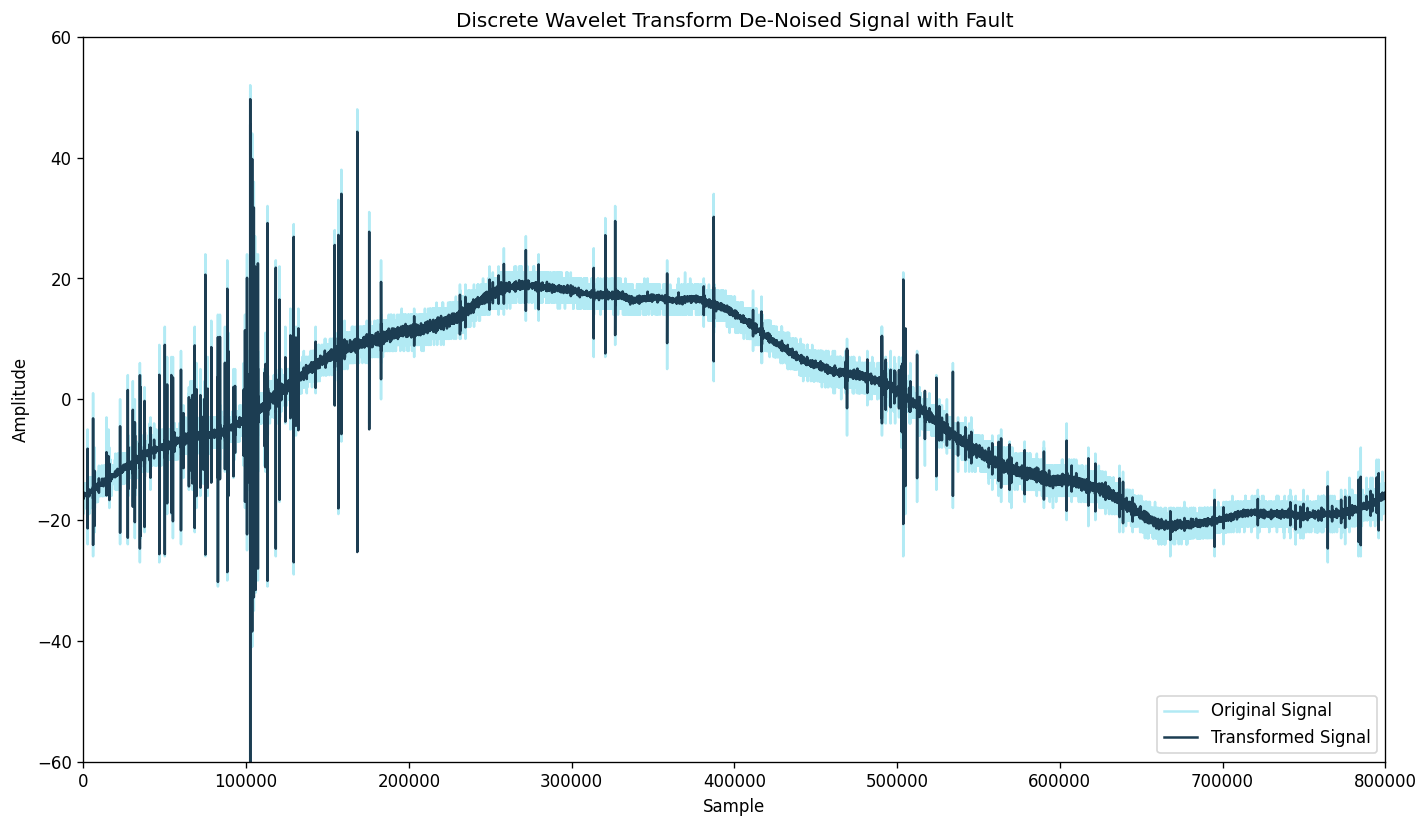

In [65]:
title0 = 'Discrete Wavelet Transform De-Noised Signal without Fault'
title1 = 'Discrete Wavelet Transform De-Noised Signal with Fault'
signal_0 =  waveletSmoothPlots(train_df["0"], wavelet="db4", level=1, title=title0 ) 
signal_1 =  waveletSmoothPlots(train_df["3"], wavelet="db4", level=1, title=title1 )

Text(0, 0.5, 'Amplitud')

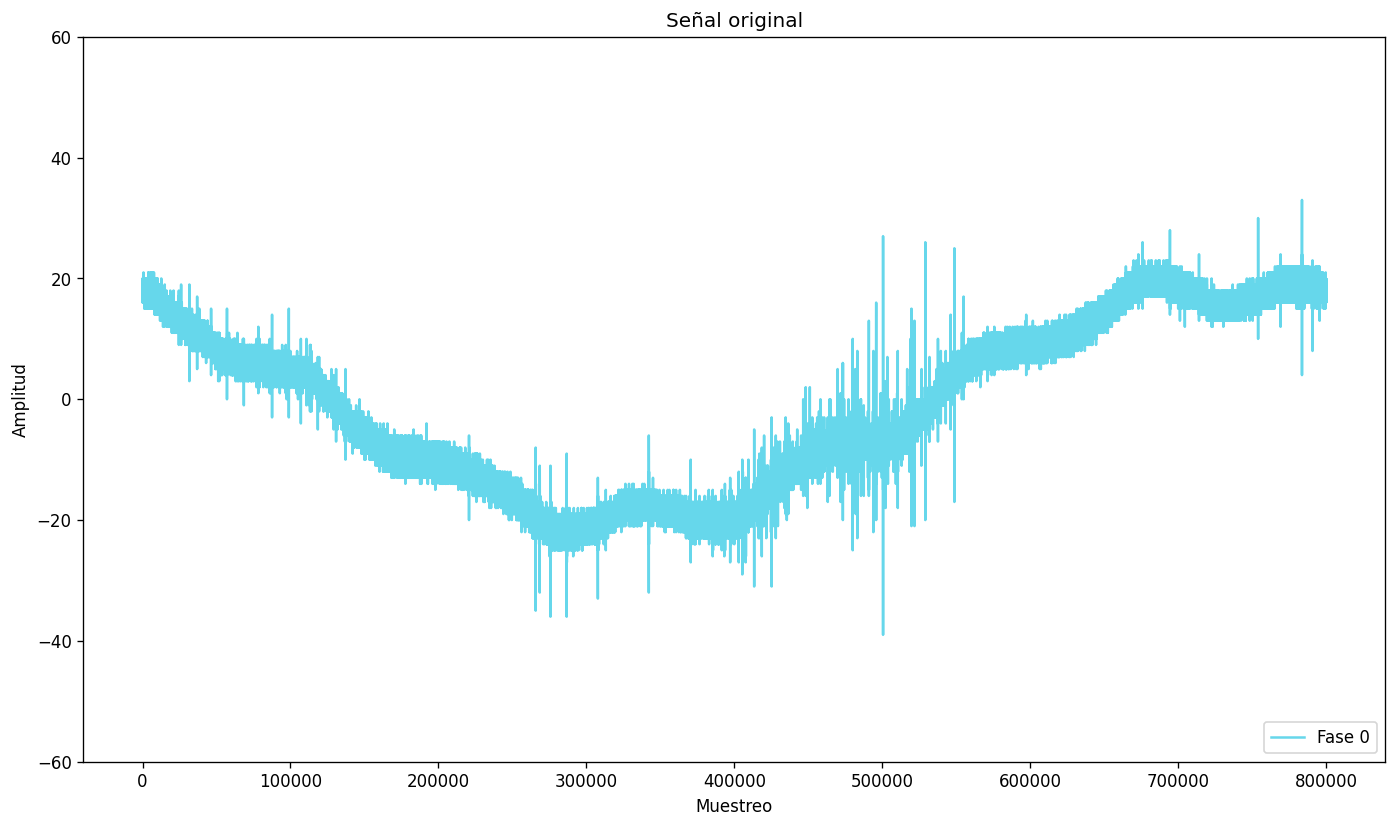

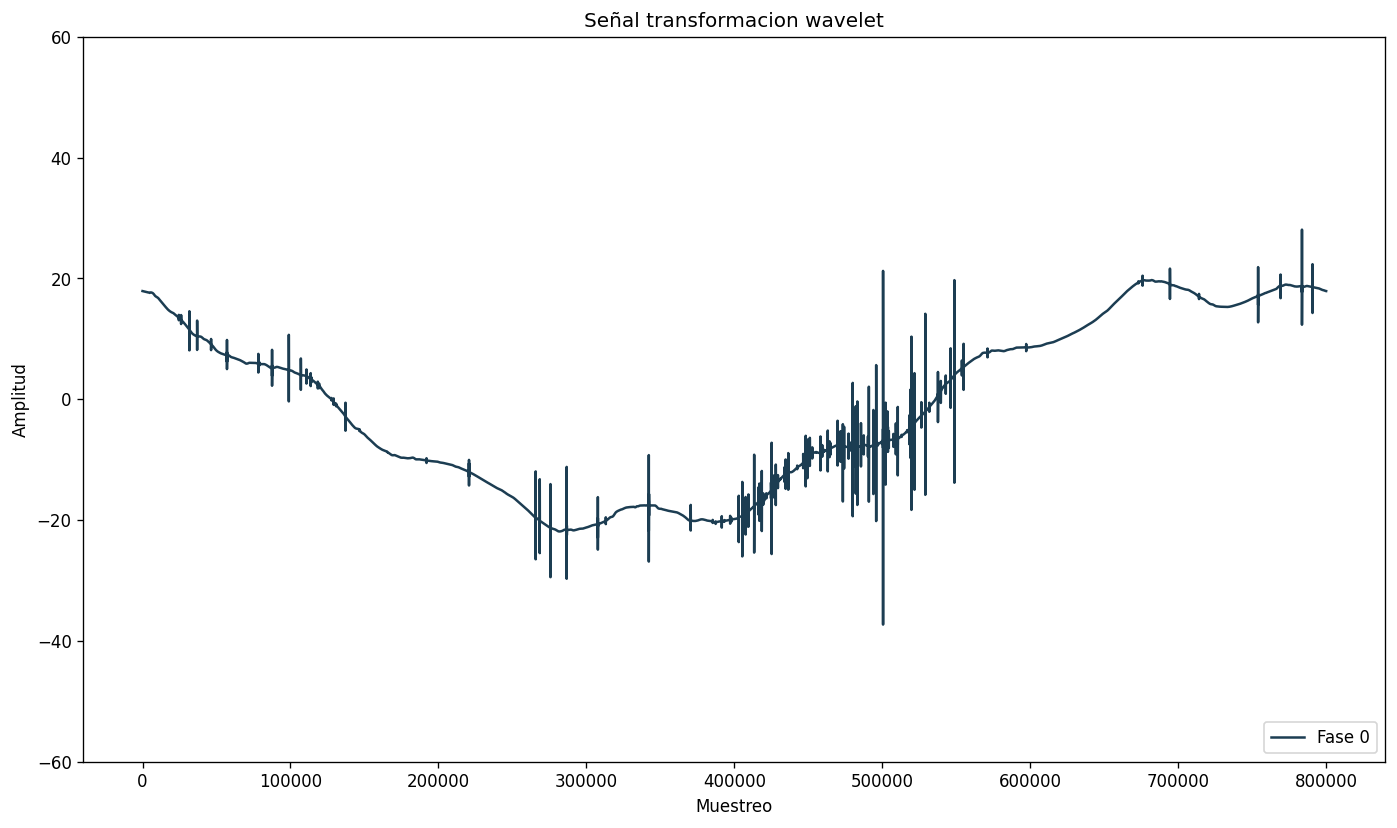

In [63]:
# Comparacion señal antes y despues

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Fase 0', 'Fase 1', 'Fase 2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(train_df))), train_df["0"], '-', label=plot_labels[0], color=blues[0])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Señal original')
plt.xlabel('Muestreo')
plt.ylabel('Amplitud')

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Fase 0', 'Fase 1', 'Fase 2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(train_df))), wavelet_df["0"], '-', label=plot_labels[0], color=blues[4])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Señal transformacion wavelet')
plt.xlabel('Muestreo')
plt.ylabel('Amplitud')

### Modelado

#### Modelo con caracteristicas básicas como baseline

In [11]:
# Extraccion de características básicas

%%time
train_length = 8712
positive_length = len(meta_train_df[meta_train_df['target']==1])
train_df_blm = pd.DataFrame()
row_index = 0
for i in range(train_length):
    # downsampling
    if meta_train_df.loc[i,'target'] == 1 or random.random() < positive_length / train_length:
        subset_train_row = train_df[str(i)]
        train_df_blm.loc[row_index, 'signal_min'] = subset_train_row.min()
        train_df_blm.loc[row_index, 'signal_max'] = subset_train_row.max()
        train_df_blm.loc[row_index, 'signal_mean'] = subset_train_row.mean()
        # *** Add your feature here ***
        train_df_blm.loc[row_index, 'signal_id'] = i
        row_index += 1
print("positive length: " + str(positive_length))
# positive length 525
print("train length: " + str(len(train_df_blm)))
# train length 1038  example
# This will be about 1050

positive length: 525
train length: 1028
CPU times: total: 2.84 s
Wall time: 3.03 s


In [84]:
# Extraccion de características básicas

train_length = 8712 #max 8712
positive_length = len(meta_train_df[meta_train_df['target']==1])
train_df_blm = pd.DataFrame()
row_index = 0
for i in range(train_length):
    train_row = train_df[str(i)]
    train_df_blm.loc[row_index, 'signal_min'] = train_row.min()
    train_df_blm.loc[row_index, 'signal_max'] = train_row.max()
    train_df_blm.loc[row_index, 'signal_mean'] = train_row.mean()
    train_df_blm.loc[row_index, 'signal_id'] = i
    row_index += 1


train_df_blm = pd.merge(train_df_blm, meta_train_df, on='signal_id')
train_df_blm

,signal_min,signal_max,signal_mean,signal_id,id_measurement,phase,target
0,-39.0,33.0,-0.960271,0.0,0,0,0
1,-30.0,26.0,-0.194125,1.0,0,1,0
2,-28.0,39.0,-0.043555,2.0,0,2,0
3,-77.0,52.0,-0.997401,3.0,1,0,1
4,-40.0,33.0,-0.175586,4.0,1,1,1
...,...,...,...,...,...,...,...
8707,-34.0,34.0,-1.465155,8707.0,2902,1,0
8708,-28.0,25.0,-1.473611,8708.0,2902,2,0
8709,-79.0,37.0,-1.003486,8709.0,2903,0,0
8710,-76.0,52.0,-0.170313,8710.0,2903,1,0


In [85]:
# Eliminamos la etiqueta

x_train_blm = train_df_blm.drop(['target'], axis = 1)

,signal_min,signal_max,signal_mean,signal_id,id_measurement,phase
0,-39.0,33.0,-0.960271,0.0,0,0
1,-30.0,26.0,-0.194125,1.0,0,1
2,-28.0,39.0,-0.043555,2.0,0,2
3,-77.0,52.0,-0.997401,3.0,1,0
4,-40.0,33.0,-0.175586,4.0,1,1
...,...,...,...,...,...,...
8707,-34.0,34.0,-1.465155,8707.0,2902,1
8708,-28.0,25.0,-1.473611,8708.0,2902,2
8709,-79.0,37.0,-1.003486,8709.0,2903,0
8710,-76.0,52.0,-0.170313,8710.0,2903,1


In [86]:
# Generamos el dataframe con las etiquetas de cada id

y_train_blm = train_df_blm[["signal_id", "target"]]

In [87]:
features_to_drop = [
        'target'
]

In [88]:
feature_names = sorted([c for c in train_df_blm.columns if c not in features_to_drop])

<AxesSubplot:>

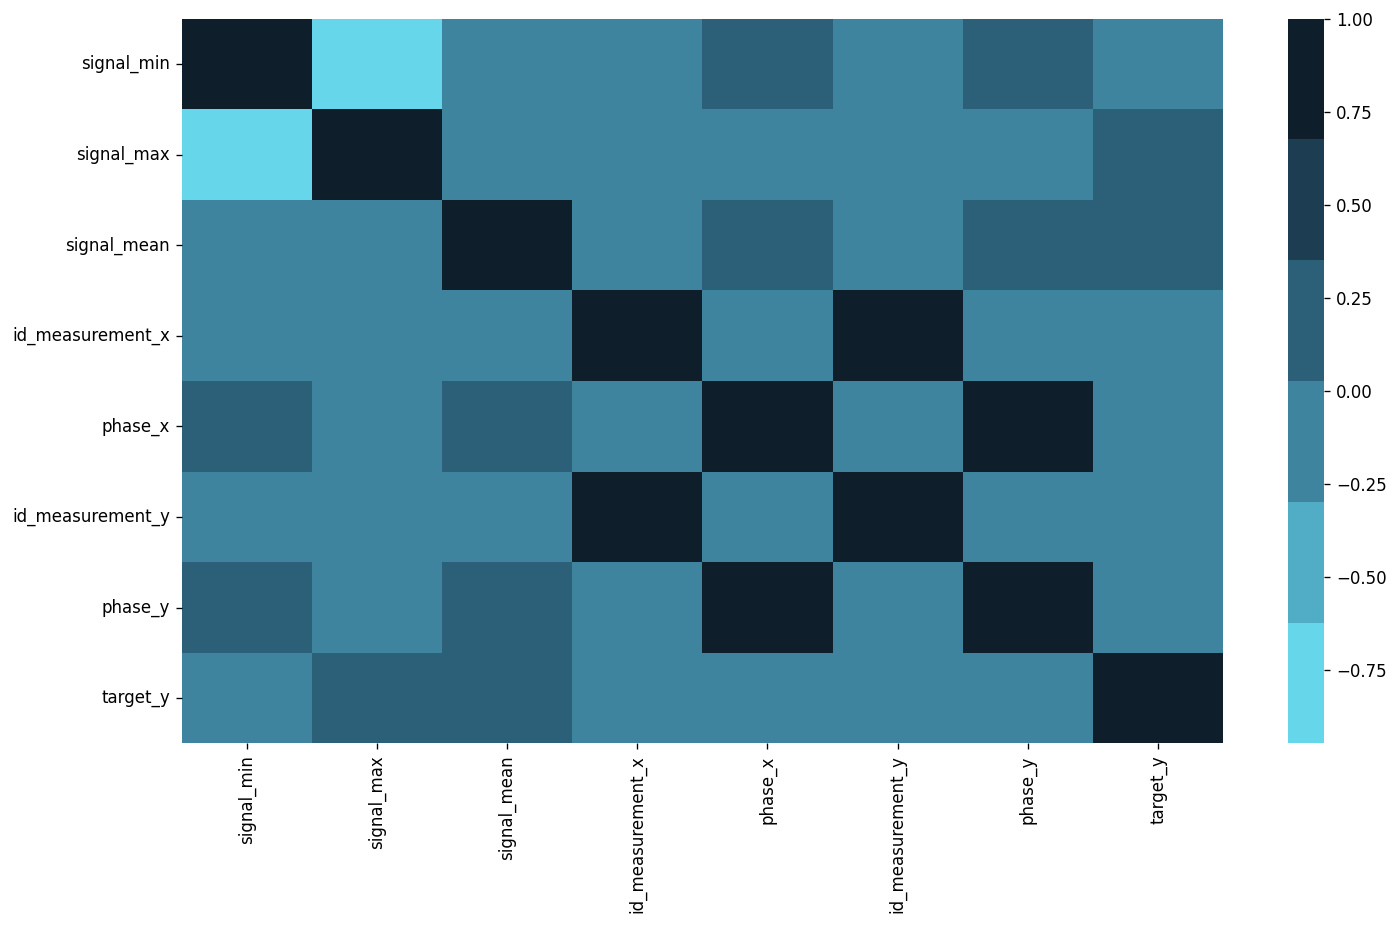

In [62]:
# Correlacion de las características

from matplotlib import pyplot as plt
import seaborn as sns
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
cor = train_df_blm.corr()
f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
sns.heatmap(cor, cmap=blues)

In [67]:
# Definir mcc y funcion de evaluacion basada en mcc

@numba.jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

#@numba.jit
def eval_mcc(y_true, y_prob, show=False):
    """
    A fast implementation of Anokas mcc optimization code.

    This code takes as input probabilities, and selects the threshold that 
    yields the best MCC score. It is efficient enough to be used as a 
    custom evaluation function in xgboost
    
    Source: https://www.kaggle.com/cpmpml/optimizing-probabilities-for-best-mcc
    Source: https://www.kaggle.com/c/bosch-production-line-performance/forums/t/22917/optimising-probabilities-binary-prediction-script
    Creator: CPMP
    """
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_proba,  best_mcc, None

In [68]:
# Definir funcion de entrenamiento


def train(
    X_data, 
    y_data,
    params,
    feature_names, 
    verbose_eval=50,
    kfold_random_state=23948,
    predict=False,
    calculate_mcc=False,
    early_stopping_rounds=10,
    num_folds=5,
    num_iterations=10,
):
    
    params = copy.deepcopy(params)
    
    models = []
    cv_scores = []
    val_cv_scores = []
    if calculate_mcc:
        mcc_scores = []
        val_mcc_scores = []
        thresholds=[]
    else:
        mcc_scores = None
        val_mcc_scores = None
        thresholds = None
        
    if predict:
        yp_train = np.zeros(X_train.shape[0])
        yp_val = np.zeros(X_train.shape[0])
        yp_test = np.zeros(X_train.shape[0])
    else:
        yp_train = None
        yp_val = None
        yp_test = None
        
    for iter in range(num_iterations):
        
        np.random.seed(kfold_random_state + iter)
        splits = np.zeros(X_data.shape[0], dtype=np.int)
        m = y_data == 1
        splits[m] = np.random.randint(0, 5, size=m.sum())
        m = y_data == 0
        splits[m] = np.random.randint(0, 5, size=m.sum())

        for fold in range(num_folds):

            val_fold = fold
            test_fold = (fold + 1) % num_folds

            train_folds = [f for f in range(num_folds) if f not in [val_fold, test_fold]]

            train_indices = np.where(np.isin(splits, train_folds))[0]
            val_indices = np.where(splits == val_fold)[0]
            test_indices = np.where(splits == test_fold)[0]

            trn = lgb.Dataset(
                X_data.values[train_indices],
                y_data[train_indices],
                feature_name=feature_names,
            )

            val = lgb.Dataset(
                X_data.values[val_indices],
                y_data[val_indices],
                feature_name=feature_names,
            )

            test = lgb.Dataset(
                X_data.values[test_indices],
                y_data[test_indices],
                feature_name=feature_names,
            )

            # train model

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = lgb.train(
                    params, 
                    trn, 
                    #num_boost_round=10000, 
                    valid_sets=(trn, test, val), 
                    valid_names=("train", "test", "validation"), 
                    fobj=None, 
                    feval=None,
                    early_stopping_rounds=early_stopping_rounds,
                    #evals_result=training_data,
                    verbose_eval=verbose_eval,
                )


            yp = None

            if predict:
                yp = model.predict(X_train.values[train_indices])
                yp_train[train_indices] += yp

                yp_val_fold = model.predict(X_train.values[val_indices])
                yp_val[val_indices] += yp_val_fold
                
                yp_test_fold = model.predict(X_train.values[test_indices])
                yp_test[test_indices] += yp_test_fold

            models.append(model)

            s = model.best_score['test']
            cv_scores.append(s[list(s.keys())[0]])

            s = model.best_score['validation']
            val_cv_scores.append(s[list(s.keys())[0]])

            if calculate_mcc:

                # find optimal probability threshold using training data
                best_proba, _, _ = eval_mcc(
                    y_train.values[train_indices].astype(np.float),
                    yp, 
                    False
                )

                # calculate validation MCC score using optimal probability threshold
                best_mcc_val = matthews_corrcoef(
                    y_train.values[val_indices].astype(np.float), 
                    yp_val_fold.astype(np.float) > best_proba
                )

                # calculate test MCC score using optimal probability threshold
                best_mcc = matthews_corrcoef(
                    y_train.values[test_indices].astype(np.float), 
                    yp_test_fold.astype(np.float) > best_proba
                )

                val_mcc_scores.append(best_mcc_val)
                mcc_scores.append(best_mcc)
                thresholds.append(best_proba)

    if yp_train is not None:
        yp_train /= ((num_folds - 2) * num_iterations)
        yp_val /= num_iterations
        yp_test /= num_iterations
            
    cv_scores = np.array(cv_scores)
    val_cv_scores = np.array(val_cv_scores)
    if calculate_mcc:
        mcc_scores = np.array(mcc_scores)
        val_mcc_scores = np.array(val_mcc_scores)
        thresholds = np.array(thresholds)
        
    return (
        models,
        cv_scores, val_cv_scores, 
        mcc_scores, val_mcc_scores, 
        yp_train, yp_val, yp_test, thresholds
    )

In [89]:
# Definición de parametros

params = {
    'objective': 'binary',
    #'is_unbalance': True,
    'boosting': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 80, # 61,
    'num_threads': 4,
    'metric': 'binary_logloss',
    'feature_fraction': 0.8,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'seed': 23974,
    'num_boost_round': 10000,
}

In [ ]:
# Entrenar modelo y analizar resultados
# Para las carecteristicas básicas del modelo base

%%time

(
    models,
    cv_scores, val_cv_scores, 
    mcc_scores, val_mcc_scores, 
    yp_train, yp_val, yp_test, thresholds
) = train(
    x_train_blm, 
    y_train_blm,
    params,
    feature_names, 
    verbose_eval=0, # 50,
    kfold_random_state=123948,
    predict=True,
    calculate_mcc=True,
    early_stopping_rounds=100,
    num_iterations=25 # 100
)

print("")
print("CV Logloss: {:.4f} +/- {:.4f} ({:.4f})".format(cv_scores.mean(), cv_scores.std()/np.sqrt(cv_scores.shape[0]), cv_scores.std()))
print("CV Val Logloss: {:.4f} +/- {:.4f} ({:.4f})".format(val_cv_scores.mean(), val_cv_scores.std()/np.sqrt(val_cv_scores.shape[0]), val_cv_scores.std()))
print("CV MCC: {:.4f} +/- {:.4f} ({:.4f})".format(mcc_scores.mean(), mcc_scores.std()/np.sqrt(mcc_scores.shape[0]), mcc_scores.std()))
print("CV VAL MCC: {:.4f} +/- {:.4f} ({:.4f})".format(val_mcc_scores.mean(), val_mcc_scores.std()/np.sqrt(val_mcc_scores.shape[0]), val_mcc_scores.std()))
print("Threshold {:.4f} +/- {:.4f}".format(thresholds.mean(), thresholds.std()/np.sqrt(thresholds.shape[0])))

##################################

best_proba_meas, _, _ = eval_mcc(
    y_train.values.astype(np.float),
    yp_train, 
    False
)

best_mcc_meas = matthews_corrcoef(
    y_train.values.astype(np.float), 
    yp_val > best_proba_meas
)

best_mcc_meas_test = matthews_corrcoef(
    y_train.values.astype(np.float), 
    yp_test > best_proba_meas
)

plt.show()

##################################

yp_train_df = pd.DataFrame(
    yp_train,
    index=X_train_full.index
)

yp_val_df = pd.DataFrame(
    yp_val,
    index=X_train_full.index
)

yp_test_df = pd.DataFrame(
    yp_test,
    index=X_train_full.index
)

train_pred = meta_train_df[['id_measurement', 'signal_id', 'target']].copy()
train_pred = pd.merge(train_pred, yp_train_df, on='id_measurement')
train_pred.rename({0:'prediction'}, axis=1, inplace=True)

val_pred = meta_train_df[['id_measurement', 'signal_id', 'target']].copy()
val_pred = pd.merge(val_pred, yp_val_df, on='id_measurement')
val_pred.rename({0:'prediction'}, axis=1, inplace=True)

test_pred = meta_train_df[['id_measurement', 'signal_id', 'target']].copy()
test_pred = pd.merge(test_pred, yp_test_df, on='id_measurement')
test_pred.rename({0:'prediction'}, axis=1, inplace=True)

best_proba, _, _ = eval_mcc(
    train_pred['target'].values.astype(np.float),
    train_pred['prediction'].values.astype(np.float),
    False
)

best_mcc = matthews_corrcoef(
    val_pred['target'].values.astype(np.float), 
    val_pred['prediction'].values.astype(np.float) > best_proba
)

best_mcc_test = matthews_corrcoef(
    test_pred['target'].values.astype(np.float), 
    test_pred['prediction'].values.astype(np.float) > best_proba
)

##################################

plt.show()

print("MCC (measurement): {:.3f}".format(best_mcc_meas))
print("MCC Test (measurement): {:.3f}".format(best_mcc_meas_test))
print("Best Probability Threshold(measurement): {:.3f}".format(best_proba_meas))

print("MCC: {:.3f}".format(best_mcc))
print("MCC Test: {:.3f}".format(best_mcc_test))
print("Best Probability Threshold: {:.3f}".format(best_proba))

In [60]:
# From https://www.kaggle.com/delayedkarma/lightgbm-cv-matthews-correlation-coeff
# Thank you!!
# If you have preprocessed data, input here and delete process method.
# x_train = pd.read_csv('../input/***/train.csv')
x_train_blm = train_df_blm
target = x_train_blm['target_x']
input_target = x_train_blm['target_x']
x_train_blm.drop('target_x', axis=1, inplace=True)
x_train_blm.drop('signal_id', axis=1, inplace=True)
features = x_train_blm.columns
param = {'num_leaves': 80,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}
max_iter=5

In [61]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(x_train_blm))
feature_importance_df = pd.DataFrame()
score = [0 for _ in range(folds.n_splits)]
for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train_blm.values, target.values)):
    print("Fold No.{}".format(fold_+1))
    trn_data = lgb.Dataset(x_train_blm.iloc[trn_idx][features],
                           label=target.iloc[trn_idx])
    val_data = lgb.Dataset(x_train_blm.iloc[val_idx][features],
                           label=target.iloc[val_idx])
    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 100)
    
    oof[val_idx] = clf.predict(x_train_blm.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    score[fold_] = sklearn.metrics.roc_auc_score(target.iloc[val_idx], oof[val_idx])
    if fold_ == max_iter - 1: break
if (folds.n_splits == max_iter):
    print("CV score: {:<8.5f}".format(sklearn.metrics.roc_auc_score(target, oof)))
else:
     print("CV score: {:<8.5f}".format(sum(score) / max_iter))

Fold No.1
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Fold No.2
Training until validation scores don't improve for 100 rounds


C:\Users\mguem\AppData\Roaming\Python\Python39\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\mguem\AppData\Roaming\Python\Python39\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\mguem\AppData\Roaming\Python\Python39\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

[100]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Fold No.3
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Fold No.4
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Fold No.5
Training until validation scores don't improve for 100 rounds


C:\Users\mguem\AppData\Roaming\Python\Python39\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\mguem\AppData\Roaming\Python\Python39\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\mguem\AppData\Roaming\Python\Python39\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

[100]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
CV score: 1.00000 


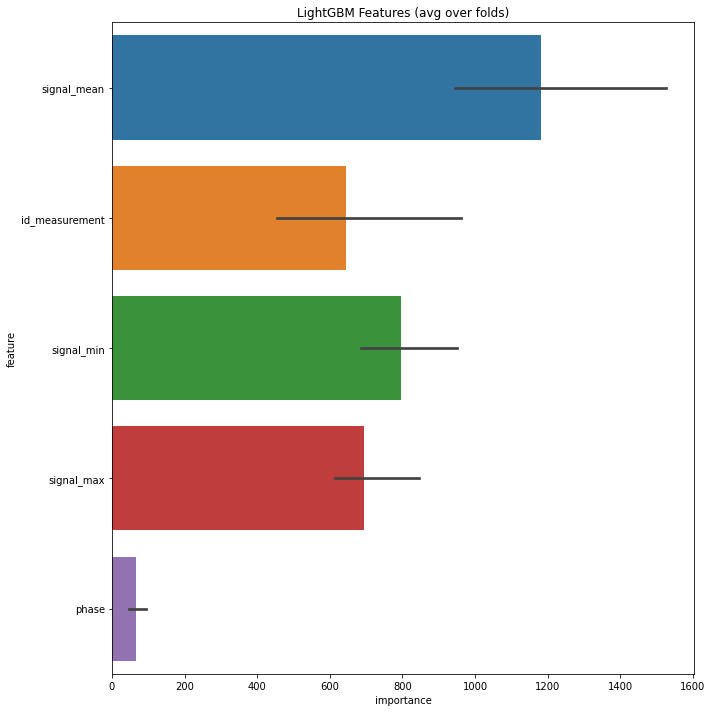

In [18]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(10,10))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

### Flatiron

In [11]:
@numba.jit(nopython=True)
def flatiron(x, alpha=100., beta=1):
    """
    Flatten signal
    
    Creator: Michael Kazachok
    Source: https://www.kaggle.com/miklgr500/flatiron
    """
    new_x = np.zeros_like(x)
    zero = x[0]
    for i in range(1, len(x)):
        zero = zero*(alpha-beta)/alpha + beta*x[i]/alpha
        new_x[i] = x[i] - zero
    return new_x

In [16]:
signal_flatiron = flatiron(signals_exploration.iloc[:,0].values, alpha=100., beta=1)

Text(0, 0.5, 'Amplitude [bit]')

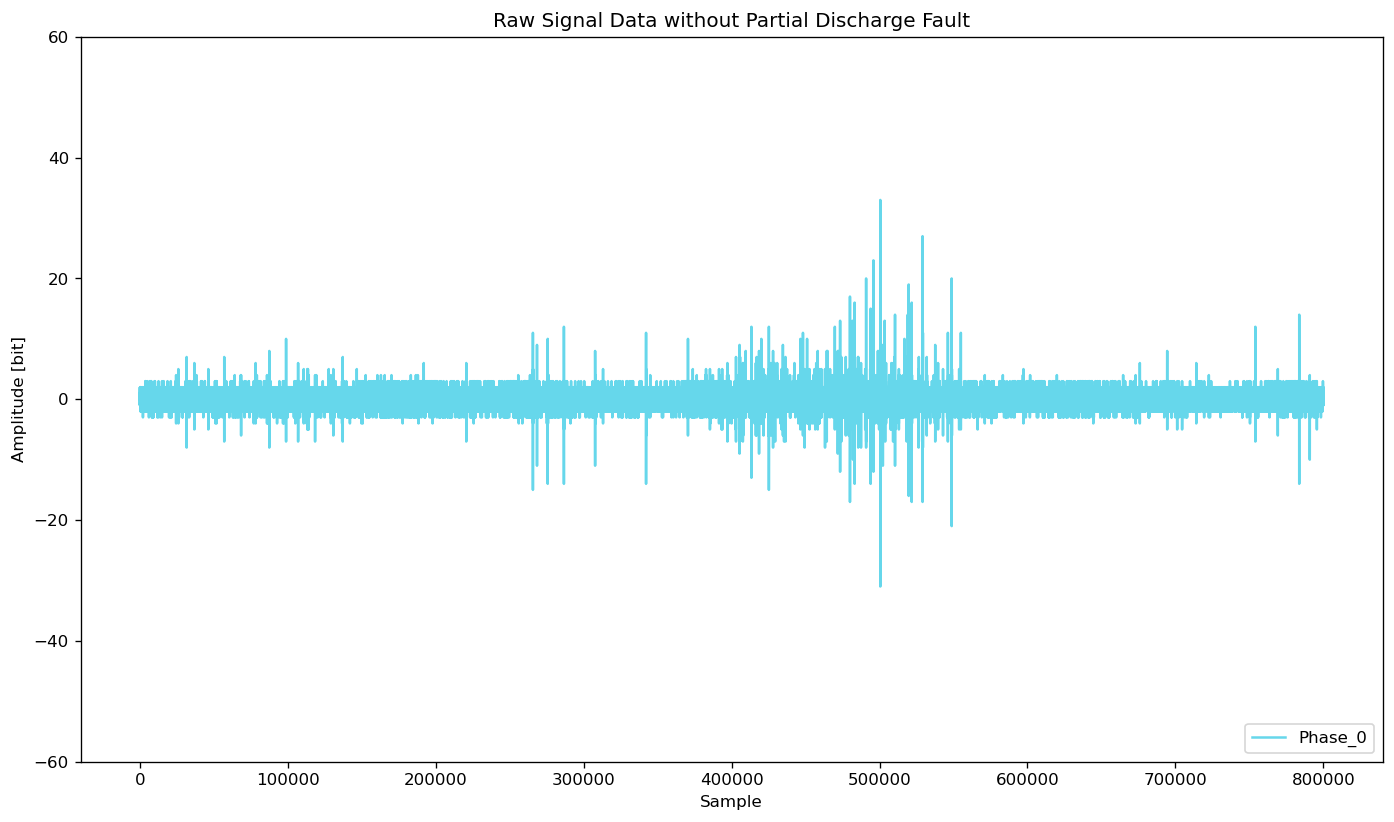

In [18]:
#Plot flatiron

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Phase_0', 'Phase_1', 'Phase_2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(signal_flatiron))), signal_flatiron, '-', label=plot_labels[0], color=blues[0])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Raw Signal Data without Partial Discharge Fault')
plt.xlabel('Sample')
plt.ylabel('Amplitude [bit]')

### Detrend signal

In [37]:
# Cargar 1 linea para pruebas
signals_2 = pq.read_table(data_dir + '\\train.parquet', columns=[str(0)]).to_pandas()
signals_2

,0
0,18
1,18
2,17
3,18
4,18
...,...
799995,19
799996,19
799997,17
799998,19


In [35]:
def detrend_signal( signal):
    
    x = np.diff(signal, n=1)
    return x

In [45]:
signal_detrend = detrend_signal(signals_2.iloc[:,0])
signal_detrend

array([ 0, -1,  1, ..., -2,  2, -2], dtype=int8)

Text(0, 0.5, 'Amplitude [bit]')

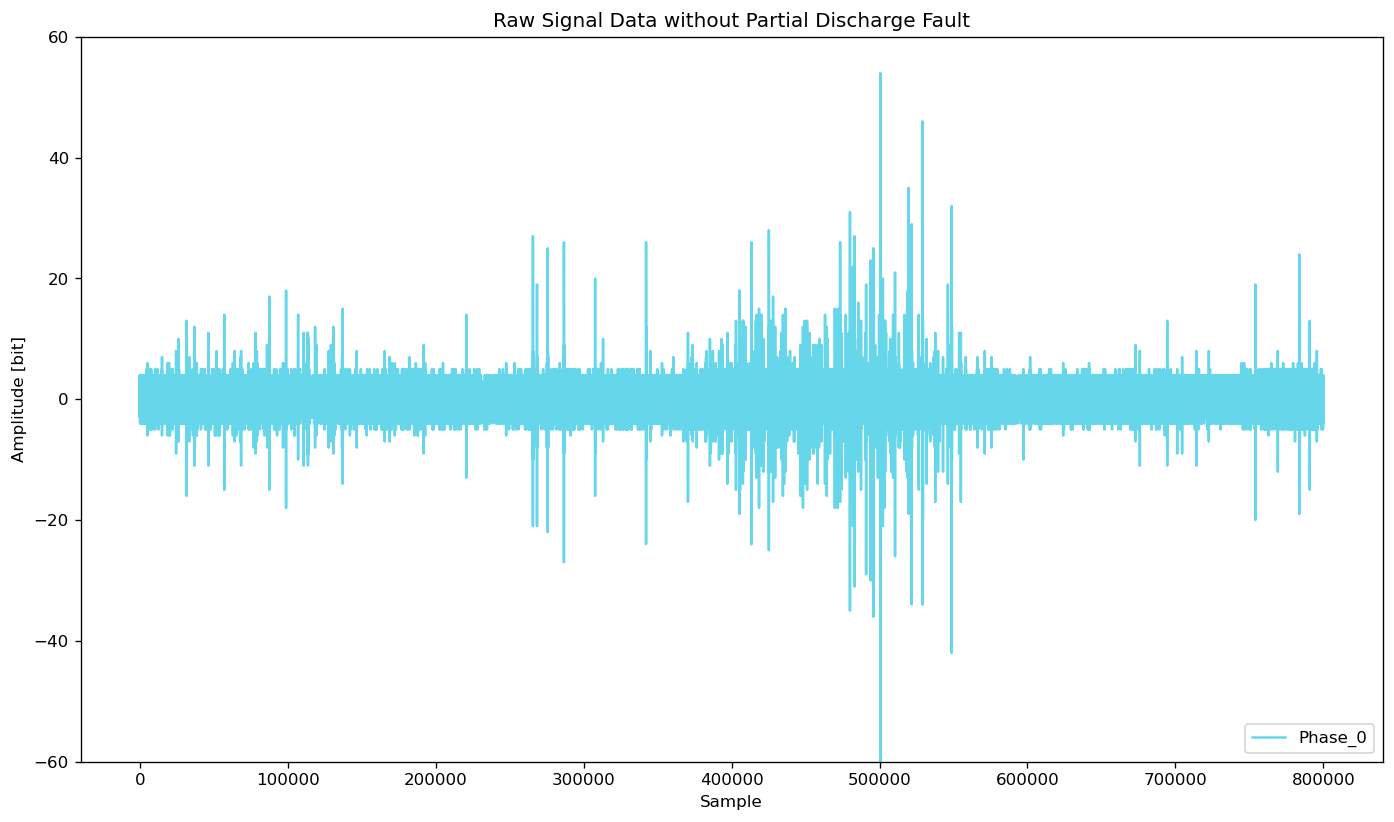

In [47]:
#Plot detrend

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Phase_0', 'Phase_1', 'Phase_2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(signal_detrend))), signal_detrend, '-', label=plot_labels[0], color=blues[0])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Raw Signal Data without Partial Discharge Fault')
plt.xlabel('Sample')
plt.ylabel('Amplitude [bit]')

### Wavelet

In [39]:
def waveletSmooth( x, wavelet="db4", level=1):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    return y

In [49]:
#signal_wavelet = waveletSmooth( signals_2.iloc[:,0], wavelet="db4", level=1)
signal_wavelet = waveletSmooth( signal_flatiron, wavelet="db4", level=1)
signal_wavelet

array([0.08170326, 0.08166613, 0.08162906, ..., 0.08181507, 0.08177769,
       0.08174042])

Text(0, 0.5, 'Amplitude [bit]')

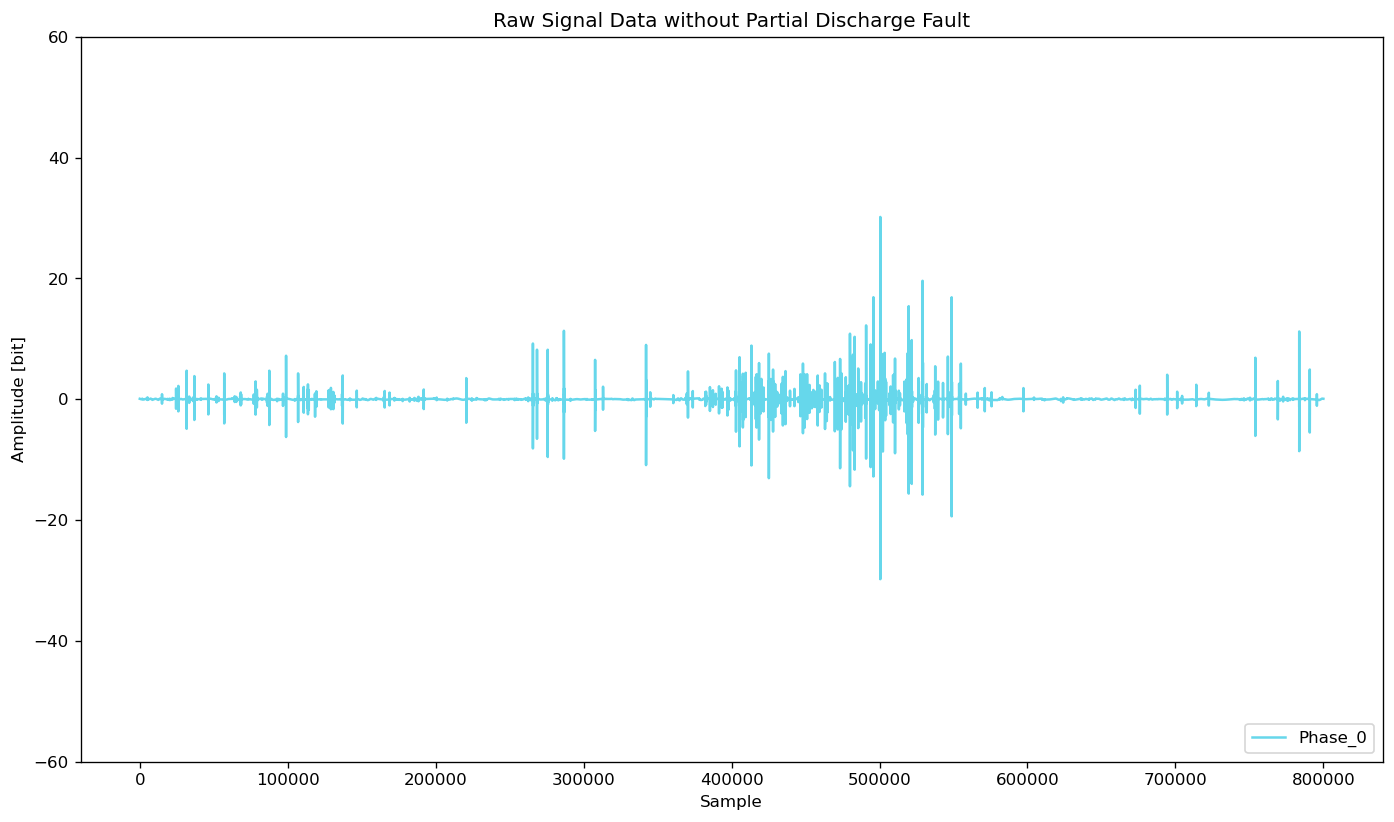

In [50]:
fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Phase_0', 'Phase_1', 'Phase_2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(signal_wavelet))), signal_wavelet, '-', label=plot_labels[0], color=blues[0])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Raw Signal Data without Partial Discharge Fault')
plt.xlabel('Sample')
plt.ylabel('Amplitude [bit]')

### High pass filter

In [60]:
SAMPLING_FREQ = 800000/0.02 # 80,000 data points taken over 20 ms
def add_high_pass_filter(signals, low_freq=10000, sample_fs=SAMPLING_FREQ):
  # Fault pattern usually exists in high frequency band. According to literature, the pattern is visible above 10^4 Hz.
  sos = butter(10, low_freq, btype='hp', fs=sample_fs, output='sos')
  filtered_sig = signal.sosfilt(sos, signals)

  return filtered_sig

In [61]:
signal_hpf = add_high_pass_filter (signals_2)
signal_hpf

array([[17.90985529],
       [17.90985529],
       [16.91486333],
       ...,
       [16.91486333],
       [18.90484725],
       [16.91486333]])

Text(0, 0.5, 'Amplitude [bit]')

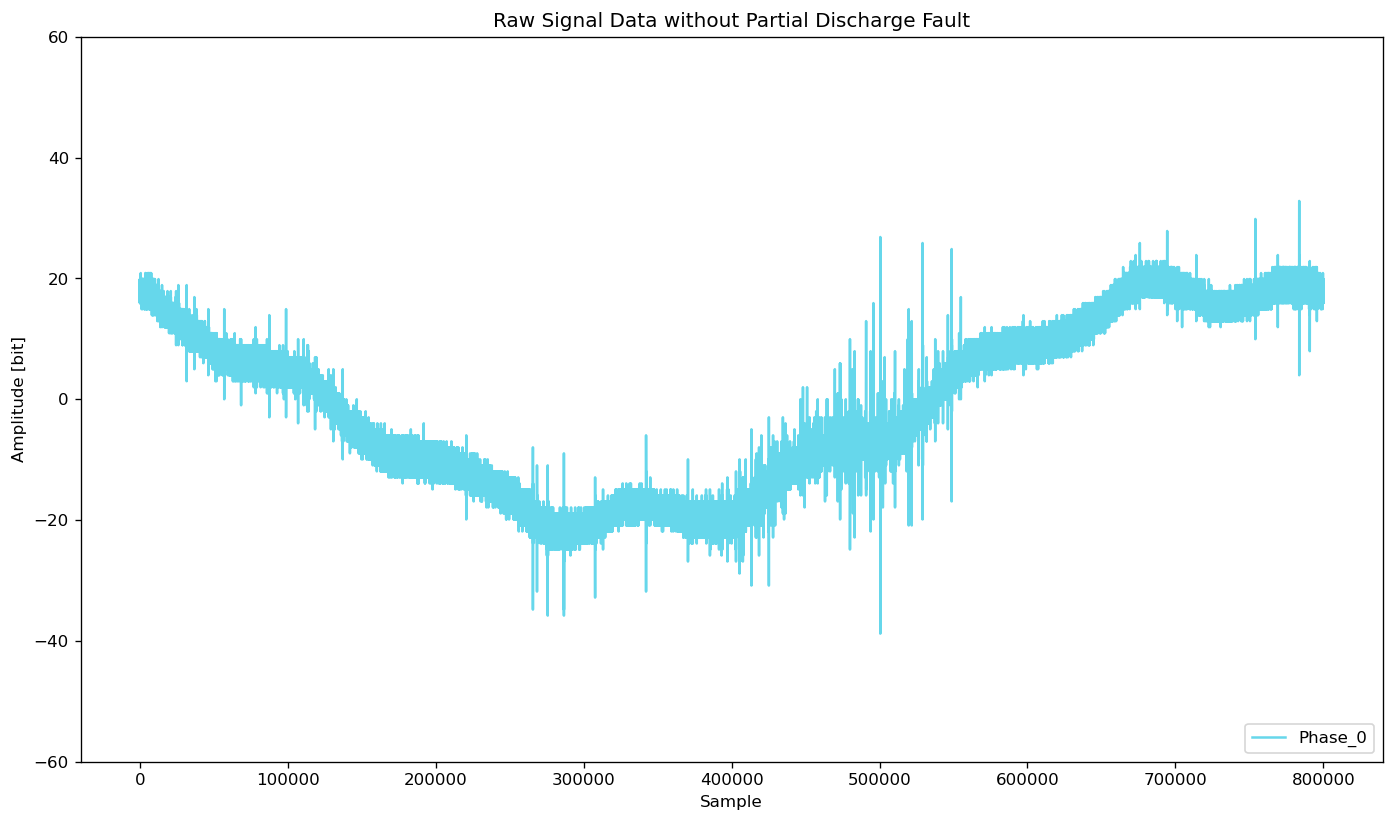

In [62]:
fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Phase_0', 'Phase_1', 'Phase_2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(signal_hpf))), signal_hpf, '-', label=plot_labels[0], color=blues[0])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Raw Signal Data without Partial Discharge Fault')
plt.xlabel('Sample')
plt.ylabel('Amplitude [bit]')

In [57]:
def rms_normalize_signal(signal):
  return signal / (np.sqrt(np.sum(signal ** 2) / len(signal)))

In [58]:
signal_norm = rms_normalize_signal(signal_hpf)
signal_norm

array([[1.29459852],
       [1.29459852],
       [1.22267638],
       ...,
       [1.22267638],
       [1.36652066],
       [1.22267638]])

Text(0, 0.5, 'Amplitude [bit]')

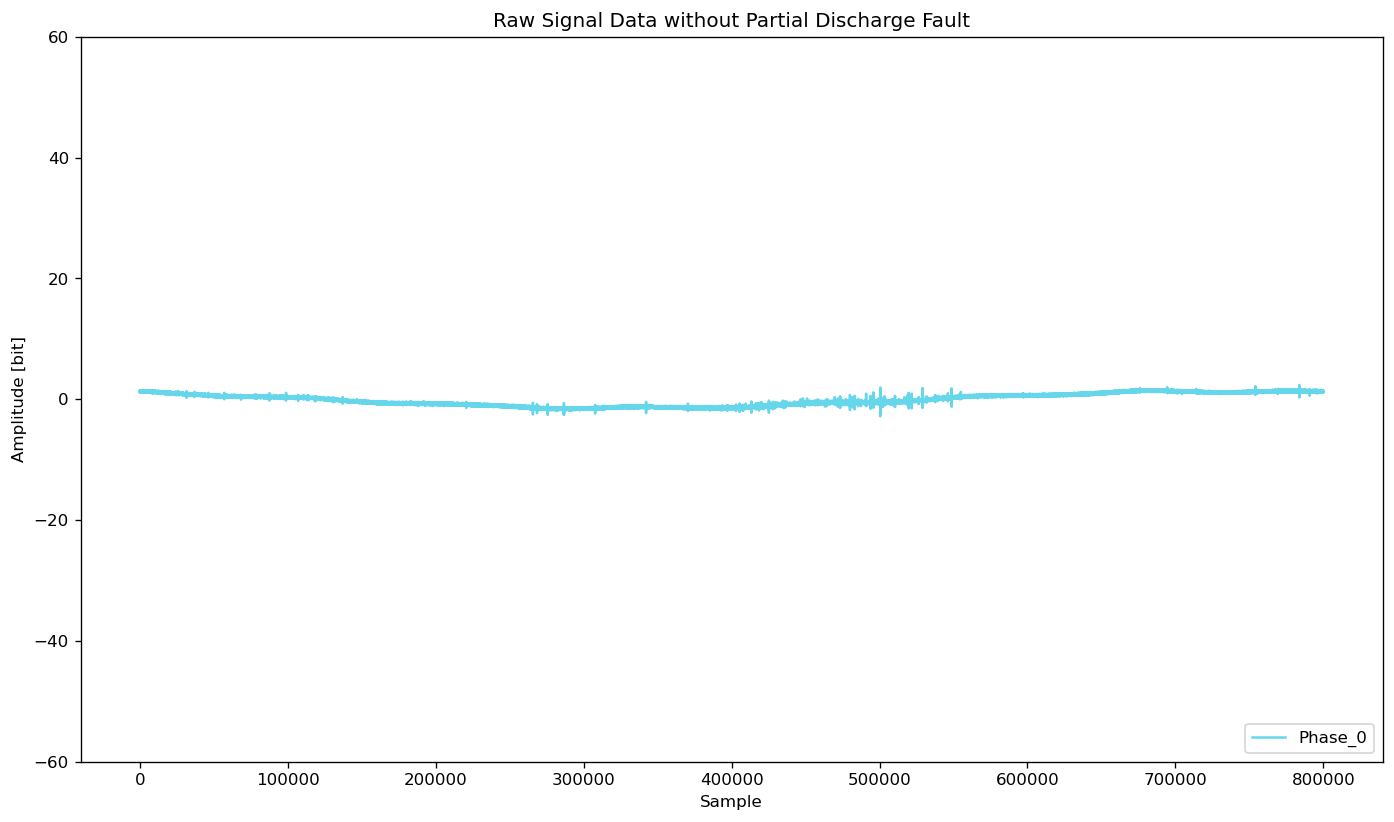

In [59]:
fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Phase_0', 'Phase_1', 'Phase_2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(signal_norm))), signal_norm, '-', label=plot_labels[0], color=blues[0])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Raw Signal Data without Partial Discharge Fault')
plt.xlabel('Sample')
plt.ylabel('Amplitude [bit]')

In [ ]:
# Extraccion de características básicas

%%time
train_length = 8712
positive_length = len(meta_train_df[meta_train_df['target']==1])
train_df_blm = pd.DataFrame()
row_index = 0
for i in range(train_length):
    # downsampling
    if meta_train_df.loc[i,'target'] == 1 or random.random() < positive_length / train_length:
        subset_train_row = train_df[str(i)]
        train_df_blm.loc[row_index, 'signal_min'] = subset_train_row.min()
        train_df_blm.loc[row_index, 'signal_max'] = subset_train_row.max()
        train_df_blm.loc[row_index, 'signal_mean'] = subset_train_row.mean()
        # *** Add your feature here ***
        train_df_blm.loc[row_index, 'signal_id'] = i
        row_index += 1
print("positive length: " + str(positive_length))
# positive length 525
print("train length: " + str(len(train_df_blm)))
# train length 1038  example
# This will be about 1050


In [ ]:
# Extraccion de características básicas

train_length = 8712 #max 8712
positive_length = len(meta_train_df[meta_train_df['target']==1])
train_df_blm = pd.DataFrame()
row_index = 0
for i in range(train_length):
    train_row = train_df[str(i)]
    train_df_blm.loc[row_index, 'signal_min'] = train_row.min()
    train_df_blm.loc[row_index, 'signal_max'] = train_row.max()
    train_df_blm.loc[row_index, 'signal_mean'] = train_row.mean()
    train_df_blm.loc[row_index, 'signal_id'] = i
    row_index += 1


train_df_blm = pd.merge(train_df_blm, meta_train_df, on='signal_id')
train_df_blm

In [ ]:
# Eliminamos la etiqueta

x_train_blm = train_df_blm.drop(['target'], axis = 1)

In [ ]:
# Generamos el dataframe con las etiquetas de cada id

y_train_blm = train_df_blm[["signal_id", "target"]]

In [ ]:
features_to_drop = [
        'target'
]

In [ ]:
feature_names = sorted([c for c in train_df_blm.columns if c not in features_to_drop])

In [ ]:
# Correlacion de las características

from matplotlib import pyplot as plt
import seaborn as sns
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
cor = train_df_blm.corr()
f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
sns.heatmap(cor, cmap=blues)